# MRF Estimation.  

**This notebook is the first implementation of a segmented MRFs **




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows, fftconvolve
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import seaborn as sns

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change these paths to point at your data and stimulus directories
path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
path_base = '/aquila_ssd2/lthomas/Projects/pySTRF_exampledata'
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(path_base, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [129]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(path_base,cellDirName, 'conspecific')


In [130]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [131]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [132]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

In [133]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


### Generate the stimulus and response feature
The stimulus features are the MPS obtained for each song segment.  The song segments are obtained using a hard threshold and then merging short silences and short sounds.
The response feature is the PSTH smoothed with a hanning window.

In [217]:
# Segmentation based on derivative of the envelope
plot = False
ampThresh = 20.0  # Threshold in dB where 50 is max

minSound = 25  # Minimum distance between peaks or troffs
derivativeThresh = 0.3  # Thresnold derivative 0.5 dB per ms.
segmentBuffer = 10 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 200 # Total chunk length (including segment buffer) in number of points 
DBNOISE = 60  # Set a baseline for everything below 70 dB from max


wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH
wHann = wHann/sum(wHann)

srData

for iSet in range(pairCount) :
    events = dict({
        'index': [],
        'feature': [[]],
    })

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    spectro = np.copy(srData['datasets'][iSet]['stim']['tfrep']['spec'])
    dBMax = spectro.max()
    spectro[spectro < dBMax-DBNOISE] = dBMax-DBNOISE

    ampenv = np.mean(spectro, axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']

    nSound = int((respChunkLen)*fs/ampfs)   # number of time points in sound chunks - should be the same for all stimulus-response pairs

    ampenv = np.convolve(ampenv, wHann, mode='same')
    ampdev = ampenv[1:]-ampenv[0:-1]
    
    # Find peaks and troughs
    peakInd, peakVals = find_peaks(ampdev, height = derivativeThresh, distance=minSound)
    troughInd, troughVals = find_peaks(-ampdev, height= derivativeThresh, distance=minSound)
    events['index'].extend(peakInd)
    events['onoff_feature'] =  np.vstack([np.ones(len(peakInd), dtype=int), np.zeros(len(peakInd), dtype=int)]).T
    events['index'].extend(troughInd)
    events['onoff_feature'] = np.concatenate( [events['onoff_feature'],np.vstack([np.zeros(len(troughInd), dtype=int), np.ones(len(troughInd), dtype=int)]).T])
    # sort the features by index
    events['onoff_feature'] = events['onoff_feature'][np.argsort(events['index'])]
    events['index'] = np.sort(events['index'])

    # now get the features from the spectrogram

    # pad the spectrogram with zeros to make sure we have enough points for windowing
    padded_spect = np.pad(spectro, ((0,0), (respChunkLen, respChunkLen)), 'constant', constant_values=(dBMax-DBNOISE, dBMax-DBNOISE))
    # now get the sliding window view
    spect_windows = np.lib.stride_tricks.sliding_window_view(padded_spect, respChunkLen,axis=1)
    # now get the indices of the start of the spectrograms
    # for ON features we take the index of the peak and subtract the segment buffer
    # for OFF features we take the index of the trough and subtract the respChunkLen
    spect_inds = events['index'] + respChunkLen - segmentBuffer * events['onoff_feature'][:,0] - (respChunkLen - segmentBuffer) * events['onoff_feature'][:,1]
    events['spect_windows'] = spect_windows[:, spect_inds,:].swapaxes(0,1)
    events['spect_inds'] = spect_inds

    # now create the features
    nFeats = nStimChannels*respChunkLen
    spect_feats = events['spect_windows'].reshape((len(events['index']), nFeats))
    srData['datasets'][iSet]['events'] = events

    # smooth the psth
    srData['datasets'][iSet]['resp']['psth_smooth'] = np.convolve(srData['datasets'][iSet]['resp']['psth'], wHann, mode='same')

    if plot:
        plt.figure(figsize=(8,2), dpi=100)
        plt.plot(ampdev)
        plt.axhline(derivativeThresh, color = 'k')

        for soundStart in peakInd:
            soundFinish = np.argwhere(troughInd >= soundStart + minSound)
            if soundFinish.shape[0]:
                dt = troughInd[soundFinish[0][0]]-soundStart
                # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
                if dt < minSound:
                    print('WARNING - not expecting short sound here', int(soundStart), int(troughInd[soundFinish[0][0]]+1))

        for soundStart in peakInd:
            plt.plot([soundStart, soundStart], [0, np.max(ampdev)*1.1], 'r')

        for soundEnd in troughInd:
            plt.plot([soundEnd, soundEnd], [0, -np.max(ampdev)*1.1], 'b')


In [174]:
# Use PCA to reduce the dimensionality of the spectrogram features
all_spect_windows = np.concatenate([srData['datasets'][iSet]['events']['spect_windows'].reshape((len(srData['datasets'][iSet]['events']['index']), nFeats)) for iSet in range(pairCount)], axis=0)
npcs = 20
pca = PCA(n_components=npcs)
pca.fit(all_spect_windows)
for iSet in range(pairCount):
    on_off_features = srData['datasets'][iSet]['events']['onoff_feature']
    n_events = len(srData['datasets'][iSet]['events']['index'])
    spect_pca_features = pca.transform(srData['datasets'][iSet]['events']['spect_windows'].reshape((n_events, nFeats)))
    srData['datasets'][iSet]['events']['spect_pca_features'] = np.zeros((n_events, 2*npcs))
    srData['datasets'][iSet]['events']['spect_pca_features'][on_off_features[:,0]==1,0:npcs] = spect_pca_features[on_off_features[:,0]==1,:]
    srData['datasets'][iSet]['events']['spect_pca_features'][on_off_features[:,1]==1,npcs:] = spect_pca_features[on_off_features[:,1]==1,:]



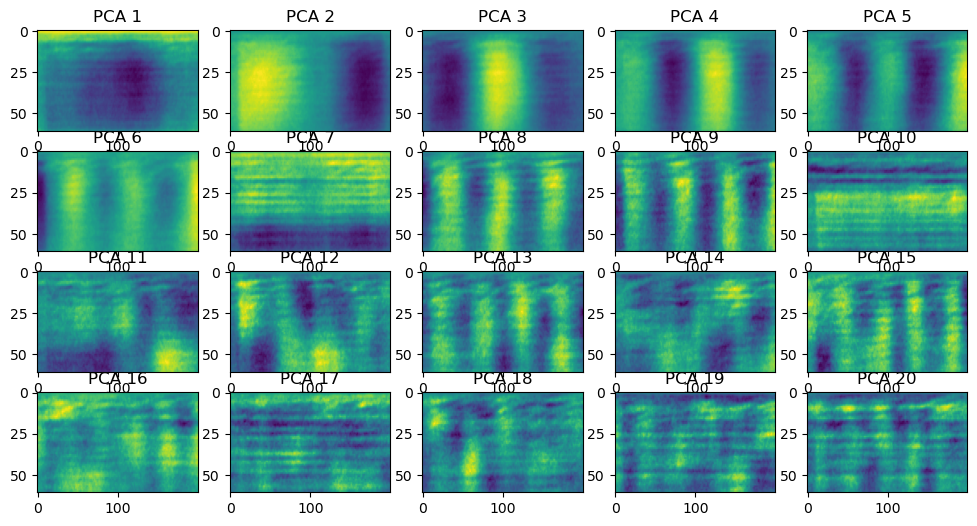

In [175]:
# plot pca components, two rows of 5
nCols = 5
nRows = npcs // nCols
fig, axs = plt.subplots(nRows, nCols, figsize=(12, 6))
for i in range(npcs):
    ax = axs[i // nCols, i % nCols]
    ax.imshow(pca.components_[i].reshape(nStimChannels, respChunkLen), aspect='auto', cmap='viridis')
    ax.set_title(f'PCA {i+1}')

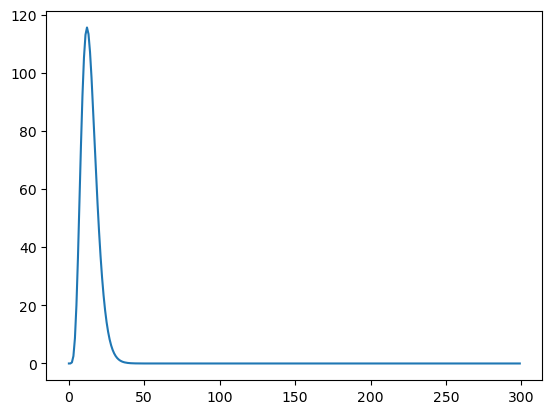

In [176]:
def laguerre(amp, tau, alpha, xorder, npts ):
    xt = np.arange(npts)
    return amp * np.exp(-xt/tau)*np.power(xt/tau, alpha)*genlaguerre(xorder, alpha)(xt/tau)
x_t = np.arange(0,300)
laguerre_func_1_amp = laguerre(amp=1, tau=2, alpha=6,xorder=0,npts=300)
plt.plot(x_t, laguerre_func_1_amp)


fftconvolve took 0.0004858970642089844 seconds
conv took 0.0012416839599609375 seconds
dot took 0.0019223690032958984 seconds


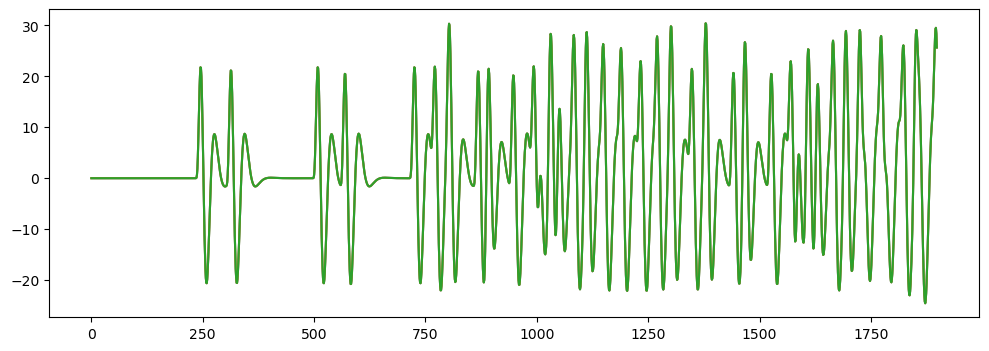

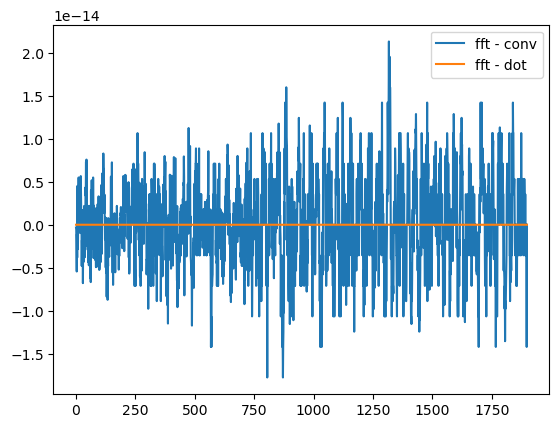

In [233]:
import time
# lets test the convolution stuff
def test_convolution(pair, feature_key, nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5):
    nT = pair['resp']['psth'].size
    nFeatures = pair['events'][feature_key].shape[1]
    X = np.zeros((nFeatures*nLaguerre, nT))
    # laguerre functions for each order
    # the order of the matrix's rows are: Laguerre order 0-nLaguerre for feature 1, Laguerre order 0-0-nLaguerre for feature 2, ...
    laguerre_mat = np.zeros(( nFeatures*nLaguerre,nLaguerrePoints))
    for iLaguerre in range(nLaguerre):
        laguerre_func = laguerre(amp=laguerre_amp, tau=laguerre_tau, alpha=laguerre_alpha, xorder=iLaguerre, npts=nLaguerrePoints)
        laguerre_mat[iLaguerre::nLaguerre,:] = laguerre_func[np.newaxis,:]
    # for each event we will convolve the laguerre function with the feature value
    inds = pair['events']['index'] + int(laguerre_dt_s*srData['datasets'][iSet]['resp']['sampleRate'])
    inds = np.clip(inds, 0, nT-1)
    X[:,pair['events']['index']] = np.hstack([pair['events'][feature_key]]*nLaguerre).T
    # now convolve the laguerre function with the feature value
    #X = fftconvolve(X, laguerre_mat, axes=1, mode='full')[:,:nT]
    # first lets plot the events
    plt.figure(figsize=(12, 4))
    # # lets average X over all time points and plot that
    # X_avg = np.mean(X, axis=0)
    # plt.plot(X_avg)

    # now lets convolve with fftconvolve
    t_start = time.time()
    X_out = fftconvolve(X, laguerre_mat, axes=1, mode='full')[:,:nT]
    X_avg_fft = np.mean(X_out, axis=0)
    print(f'fftconvolve took {time.time()-t_start} seconds')
    plt.plot(X_avg_fft)

    # now lets convolve with convolve1d on each axis
    t_start = time.time()

    X_out = np.zeros((nFeatures*nLaguerre, nT))
    for row in range(nFeatures*nLaguerre):
        X_out[row,:] = np.convolve(X[row,:], laguerre_mat[row,:], mode='full')[:nT]
    X_avg_conv = np.mean(X_out, axis=0)
    print(f'conv took {time.time()-t_start} seconds')
    plt.plot(X_avg_conv)

    # now lets test dot product on each event
    t_start = time.time()

    X_out = np.zeros((nFeatures*nLaguerre, nT))
    for row in range(nFeatures*nLaguerre):
        # now go through all the times X is not zero and do the dot product
        for event_time in pair['events']['index']:
            t_end = min(event_time+nLaguerrePoints, nT)
            nLaguerrePoints_t = t_end - event_time
            X_out[row, event_time:t_end] += laguerre_mat[row,:nLaguerrePoints_t] * X[row,event_time]
    X_avg_dot = np.mean(X_out, axis=0)
    print(f'dot took {time.time()-t_start} seconds')
    plt.plot(X_avg_dot)

    plt.figure()
    plt.plot(X_avg_fft - X_avg_conv, label='fft - conv')
    plt.plot(X_avg_dot - X_avg_dot, label='fft - dot')
    plt.legend()

test_convolution(srData['datasets'][iSet], 'onoff_feature', nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5)


In [244]:
def arbitrary_kernel(pair, nPoints=200):
    nT = pair['resp']['psth'].size
    feature = pair['events']['onoff_feature']
    X = np.zeros((nPoints*2, nT))
    X[:nPoints,pair['events']['index']] = feature[:,0]
    X[nPoints:,pair['events']['index']] = feature[:,1]
    kern_mat = np.vstack([np.eye(nPoints),np.eye(nPoints)])
    X = fftconvolve(X, kern_mat, axes=1, mode='full')[:,:nT]
    return X

def group_all_pairs(srData, nPoints=200):
    all_X = []
    all_y = []
    for iSet in range(pairCount):
        all_X.append(arbitrary_kernel(srData['datasets'][iSet], nPoints=nPoints))
        all_y.append(srData['datasets'][iSet]['resp']['psth'])
    return np.hstack(all_X)
# fit a function to the data
funcs = []
for iSet in range(pairCount):
    X = arbitrary_kernel(srData['datasets'][iSet], nPoints=200)
    y = srData['datasets'][iSet]['resp']['psth']
    ridge = RidgeCV()
    ridge.fit(X.T, y)
    funcs.append(ridge.coef_)


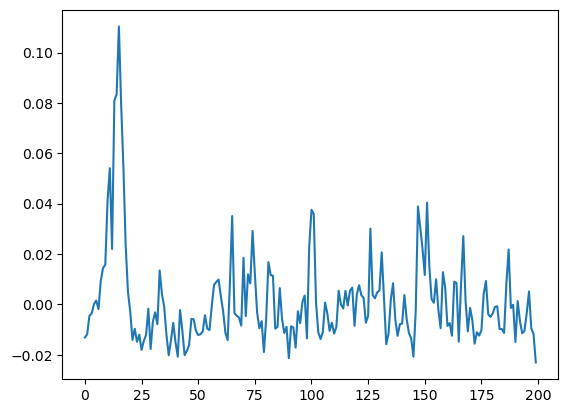

In [251]:
plt.plot(all_onsets[0])

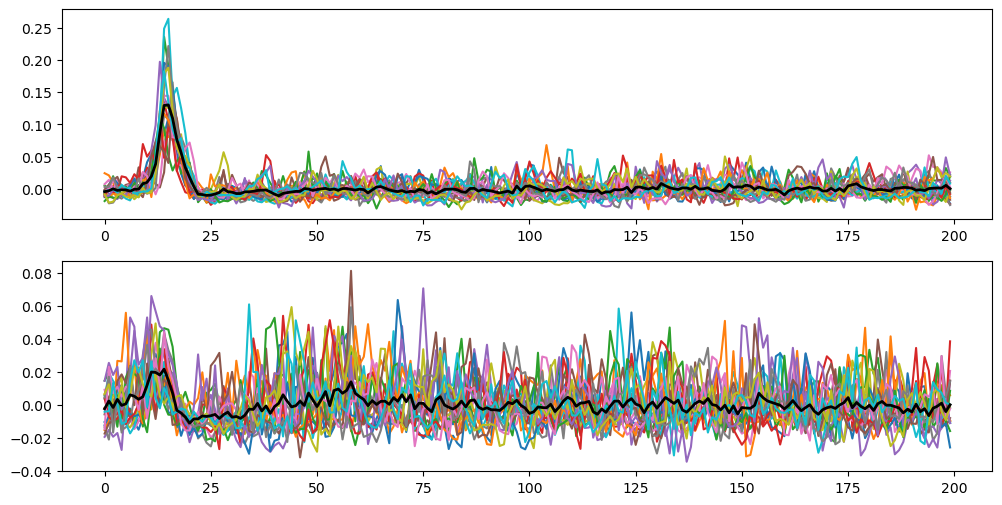

In [254]:
# lets plot all the onset responses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
all_onsets = []
all_offsets = []
for func in funcs:
    all_onsets.append(func[:200])
    all_offsets.append(func[200:])
    ax1.plot(func[:200])
    ax2.plot(func[200:])
onset = np.mean(all_onsets, axis=0)
ax1.plot(onset, color='k', linewidth=2)
offset = np.mean(all_offsets, axis=0)
ax2.plot(offset, color='k', linewidth=2)

In [234]:

    

# To generate features we will convolve the laguerre function with the feature values
def generate_laguerre_features(pair, feature_key, nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5):
    # we will generate X and Y for each pair
    nT = pair['resp']['psth'].size
    nFeatures = pair['events'][feature_key].shape[1]
    X = np.zeros((nFeatures*nLaguerre, nT))
    # laguerre functions for each order
    # the order of the matrix's rows are: Laguerre order 0-nLaguerre for feature 1, Laguerre order 0-0-nLaguerre for feature 2, ...
    laguerre_mat = np.zeros(( nFeatures*nLaguerre,nLaguerrePoints))
    for iLaguerre in range(nLaguerre):
        laguerre_func = laguerre(amp=laguerre_amp, tau=laguerre_tau, alpha=laguerre_alpha, xorder=iLaguerre, npts=nLaguerrePoints)
        laguerre_mat[iLaguerre::nLaguerre,:] = laguerre_func[np.newaxis,:]
    # for each event we will convolve the laguerre function with the feature value
    inds = pair['events']['index'] + int(laguerre_dt_s*srData['datasets'][iSet]['resp']['sampleRate'])
    inds = np.clip(inds, 0, nT-1)
    X[:,pair['events']['index']] = np.hstack([pair['events'][feature_key]]*nLaguerre).T
    # now convolve the laguerre function with the feature value
    X = fftconvolve(X, laguerre_mat, axes=1, mode='full')[:,:nT]
    return X

X = generate_laguerre_features(srData['datasets'][iSet], 'onoff_feature', nLaguerrePoints=300, nLaguerre=5, laguerre_dt_s=0, laguerre_amp=1, laguerre_tau=5, laguerre_alpha=5)
X.shape

(10, 1899)

Text(0.5, 1.0, 'Alpha')

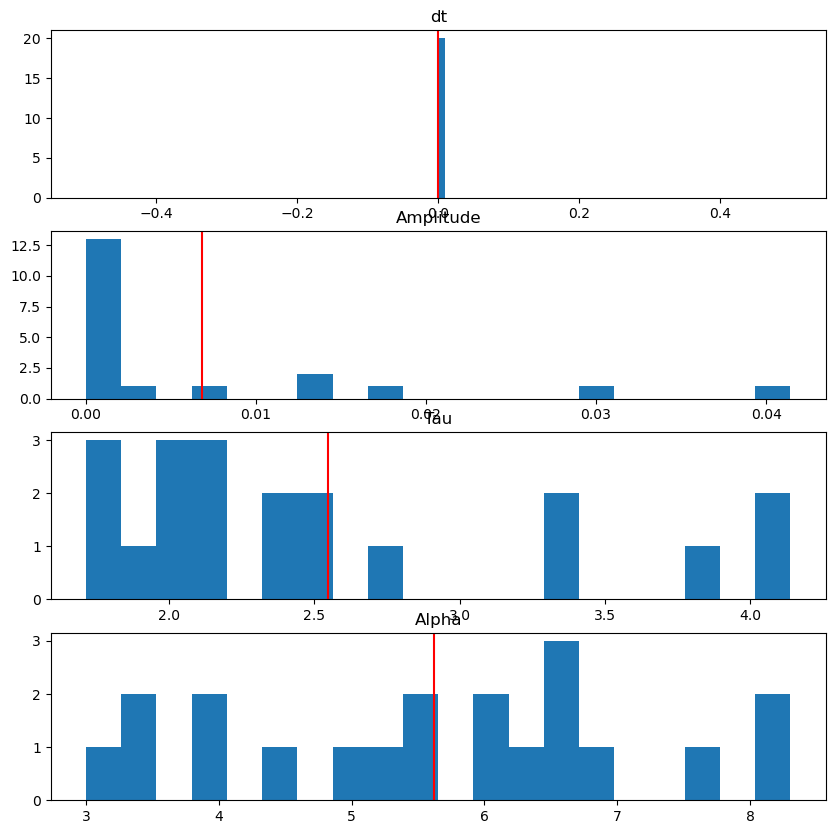

In [235]:
vals = []
# first we will fit the laguerre functions to the data
# TODO do we want to fit differnt values for onsets and offsets?
for iSet in range(pairCount):
    nFeatures = srData['datasets'][iSet]['events']['onoff_feature'].shape[1]
    y = srData['datasets'][iSet]['resp']['psth_smooth']
    amp_ratio = max(y)/max(laguerre_func_1_amp)
    def laguerre_fit_func(pair, dt, amp, tau, alpha):
        return generate_laguerre_features(pair, feature_key='onoff_feature', nLaguerrePoints=300, nLaguerre=1, laguerre_dt_s=dt, 
                                        laguerre_amp=amp, laguerre_tau=tau, laguerre_alpha=alpha).sum(axis=0)
    popt, pcov = curve_fit(laguerre_fit_func, srData['datasets'][iSet], y, p0=np.array([0, amp_ratio, 2, 5]),
                                                                    bounds=([-.02, -np.inf, -np.inf, -np.inf], [.02, np.inf, np.inf, np.inf]))
    vals.append(popt)
predicted_vals = np.array(vals)
avg_vals = np.mean(predicted_vals, axis=0)

# plot the distributions
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(10,10))
ax0.hist(predicted_vals[:,0], bins=100)
ax0.axvline(avg_vals[0], color='r')
ax0.set_title('dt')
ax1.hist(predicted_vals[:,1], bins=20)
ax1.axvline(avg_vals[1], color='r')
ax1.set_title('Amplitude')
ax2.hist(predicted_vals[:,2], bins=20)
ax2.axvline(avg_vals[2], color='r')
ax2.set_title('Tau')
ax3.hist(predicted_vals[:,3], bins=20)
ax3.axvline(avg_vals[3], color='r')
ax3.set_title('Alpha')



<Axes: ylabel='Density'>

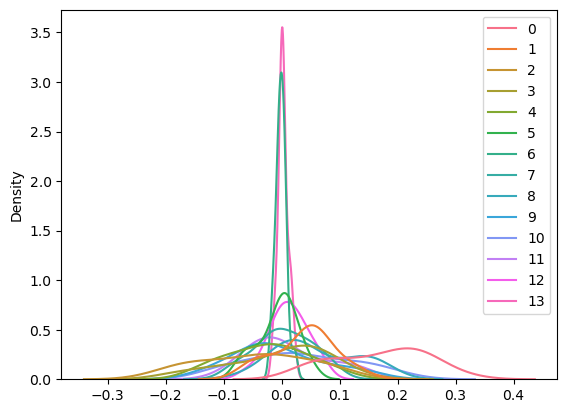

In [179]:
# now lets fit some weights
def fit_laguerre_weights(pair, lag_vals, **kwargs):
    X = generate_laguerre_features(pair, feature_key='onoff_feature', laguerre_dt_s=lag_vals[0], laguerre_amp=lag_vals[1], laguerre_tau=lag_vals[2], laguerre_alpha=lag_vals[3], **kwargs)
    y = pair['resp']['psth_smooth']
    clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    clf.fit(X.T, y)
    return clf.coef_

weights = []
nLaguerre = 7
for iSet in range(pairCount):
    w = fit_laguerre_weights(srData['datasets'][iSet], avg_vals, nLaguerrePoints=300, nLaguerre=nLaguerre)
    weights.append(w)
weights = np.array(weights)
avg_weights = np.mean(weights, axis=0)

# plot the distributions
sns.kdeplot(weights)

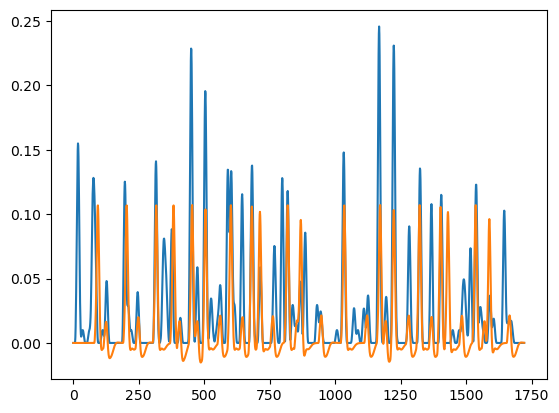

In [180]:
# pick a random pair to plot
iSet = np.random.randint(pairCount)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='onoff_feature', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ avg_weights
plt.plot(y)
plt.plot(y_pred)

In [181]:
# now lets generate the predicted response using the spectrogram feautres
# now lets fit some weights
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
def fit_laguerre_weights(pair, lag_vals, **kwargs):
    X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=lag_vals[0], laguerre_amp=lag_vals[1], laguerre_tau=lag_vals[2], laguerre_alpha=lag_vals[3], **kwargs)
    y = pair['resp']['psth_smooth']
    clf = RidgeCV(alphas=Alphas)
    clf.fit(X.T, y)
    return clf.coef_

weights = []
for iSet in range(pairCount):
    w = fit_laguerre_weights(srData['datasets'][iSet], avg_vals, nLaguerrePoints=300, nLaguerre=nLaguerre)
    weights.append(w)
    
weights = np.array(weights)
avg_weights = np.mean(weights, axis=0)


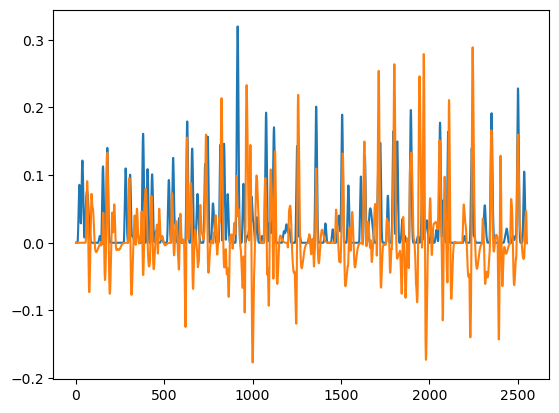

In [190]:
# pick a random pair to plot
iSet = np.random.randint(pairCount)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ avg_weights#weights[iSet]
plt.plot(y)
plt.plot(y_pred)

In [210]:
# now lets concatenate all responses and features and do one big ridge regression

X = None
Y= None
pair_test_set = np.random.choice(range(pairCount), 5, replace=False)
for iSet in range(pairCount):
    if iSet in pair_test_set:
        continue
    pair = srData['datasets'][iSet]
    x = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
    if X is None:
        X = x
    else:
        X = np.hstack([X, x])
    if Y is None:
        Y = pair['resp']['psth_smooth']
    else:
        Y = np.hstack([Y, pair['resp']['psth_smooth']])


In [211]:
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
clf.fit(X.T, Y)


RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

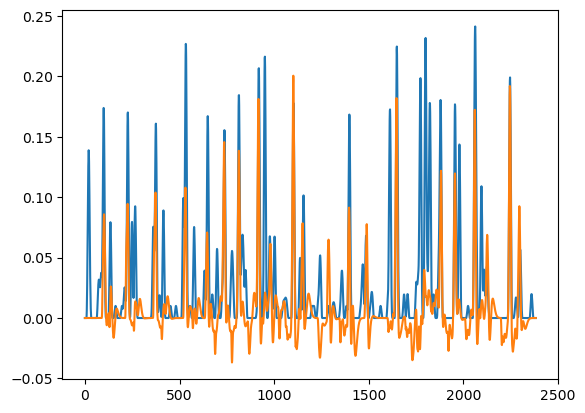

In [216]:
iSet = np.random.choice(pair_test_set)
pair = srData['datasets'][iSet]
X = generate_laguerre_features(pair, feature_key='spect_pca_features', laguerre_dt_s=avg_vals[0], laguerre_amp=avg_vals[1], laguerre_tau=avg_vals[2], laguerre_alpha=avg_vals[3], nLaguerrePoints=300, nLaguerre=nLaguerre)
y = pair['resp']['psth_smooth']
y_pred = X.T @ clf.coef_
plt.plot(y)
plt.plot(y_pred)